## BMI 500
###Questions set 5
Model-based Bias Removal in Machine Learning Using Synthetic Blood Pressure Data


In [ ]:
#II a

# Generating synthtic data for male and female using the given mean, standard deviation and the correlation coefficient

import numpy as np
import pandas as pd

# defining male statistics
male_SBP_avg = 133.0
male_SBP_std_dev = 18.6
male_DBP_avg = 78.8
male_DBP_std_dev = 12.6
male_correlation = 0.45

# defining female statistics
female_SBP_avg = 125.8
female_SBP_std_dev = 19.0
female_DBP_avg = 74.8
female_DBP_std_dev = 12.4
female_correlation = 0.5


# Total sample number of samples
total_samples = 100000

In [ ]:
def final_dataset(prevalence):

      num_males = int(prevalence *total_samples)
      num_females = total_samples-num_males

      # generating covariances for male and female
      m_cov_matrix =  np.array([[male_SBP_std_dev**2, male_correlation * male_SBP_std_dev * male_DBP_std_dev],
                              [male_correlation  * male_SBP_std_dev * male_DBP_std_dev, male_DBP_std_dev**2]])

      f_cov_matrix = np.array([[female_SBP_std_dev**2, female_correlation *female_SBP_std_dev * female_DBP_std_dev],
                              [female_correlation  * female_SBP_std_dev * female_DBP_std_dev, female_DBP_std_dev**2]])

      # Generate synthetic data for males and females
      data_males = np.random.multivariate_normal([male_SBP_avg, male_DBP_avg], m_cov_matrix, num_males)
      data_females = np.random.multivariate_normal([female_SBP_avg, female_DBP_avg],  f_cov_matrix, num_females)


      # creating the labels
      male_labels = np.ones(num_males)# assign 1 to males
      female_labels = np.zeros(num_females)# assign 0 to females

      # Combine the data and labels
      data_males_labeled = np.column_stack((data_males, male_labels))
      data_females_labeled = np.column_stack((data_females, female_labels))

      # Concatenate the male and female data with labels
      final_dataset = np.vstack((data_males_labeled, data_females_labeled))

      column_names = ['SBP', 'DBP', 'Gender']

      df_final_dataset= pd.DataFrame(final_dataset, columns=column_names)
      return df_final_dataset

In [ ]:
#III

#b.  Binary classification
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,RocCurveDisplay,roc_curve
import matplotlib.pyplot as plt


def model(df_final_dataset):
    X = df_final_dataset.iloc[:, :2]# select SPD and DBP columns
    #print(X.head(3))
    y= df_final_dataset.iloc[:,2] # select Gender column

    # Set the random seed
    np.random.seed(40)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.2, random_state = 43, shuffle ='True')
    clf = LogisticRegression()
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #evaluating the model
    accuracy = accuracy_score(y_pred, y_test)#accuracy
    f1 = f1_score(y_pred, y_test)# f1-score
    roc_auc = roc_auc_score(y_pred, y_test)# AUROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    return accuracy,f1, roc_auc,fpr, tpr, thresholds



 Prevalence:0.2	 Accuracy: 0.798	 F1-score:0.001	 AUROC:0.549



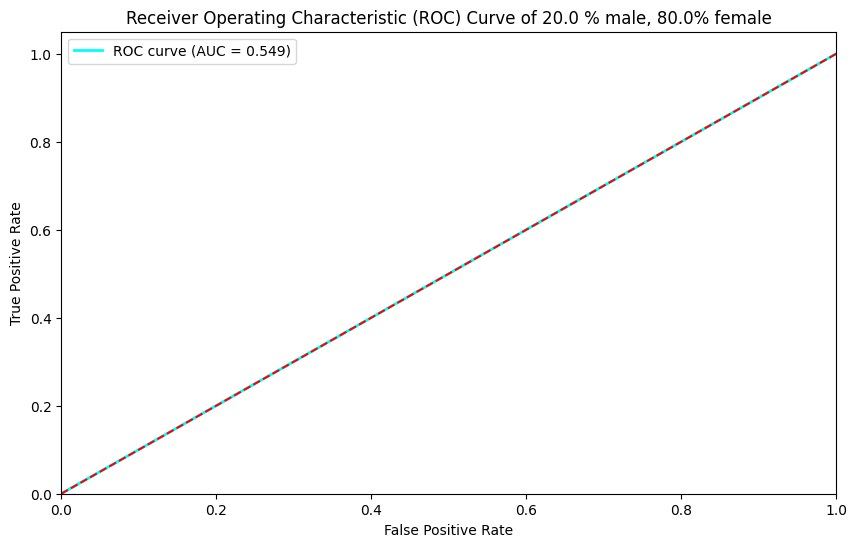


 Prevalence:0.3	 Accuracy: 0.700	 F1-score:0.064	 AUROC:0.606



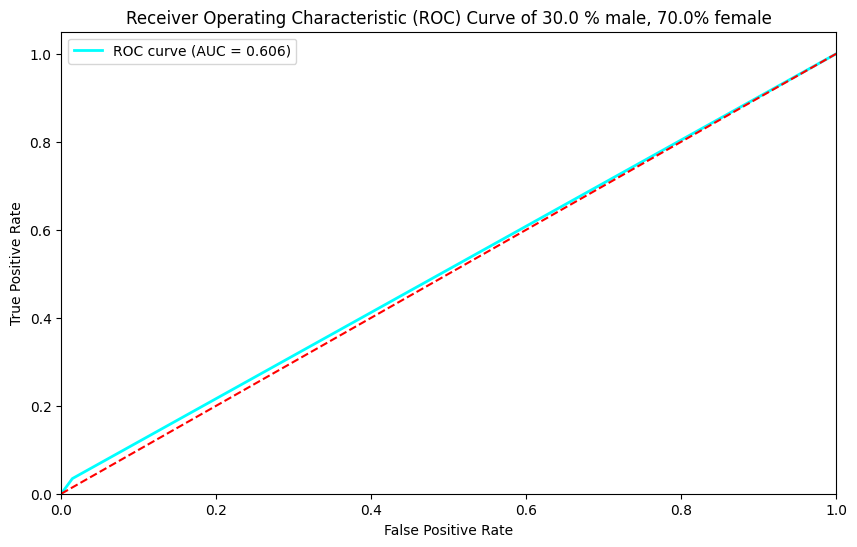


 Prevalence:0.4	 Accuracy: 0.611	 F1-score:0.307	 AUROC:0.586



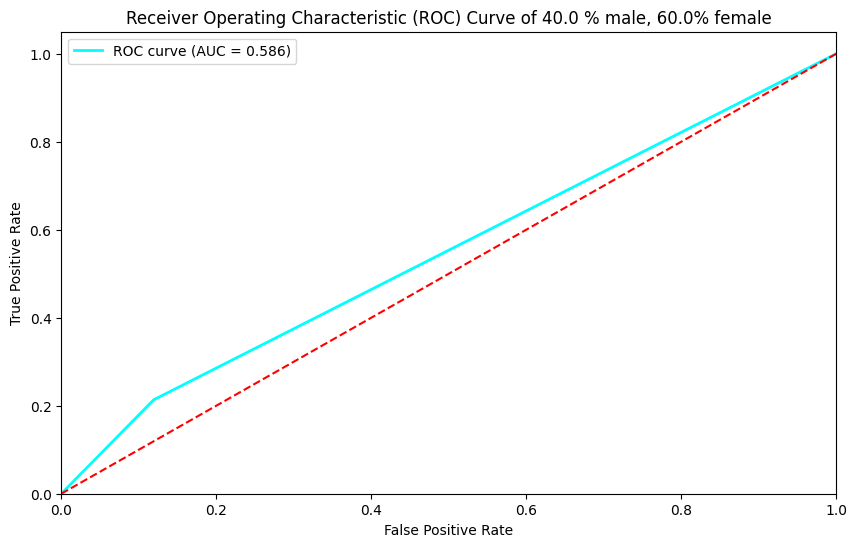


 Prevalence:0.5	 Accuracy: 0.582	 F1-score:0.581	 AUROC:0.582



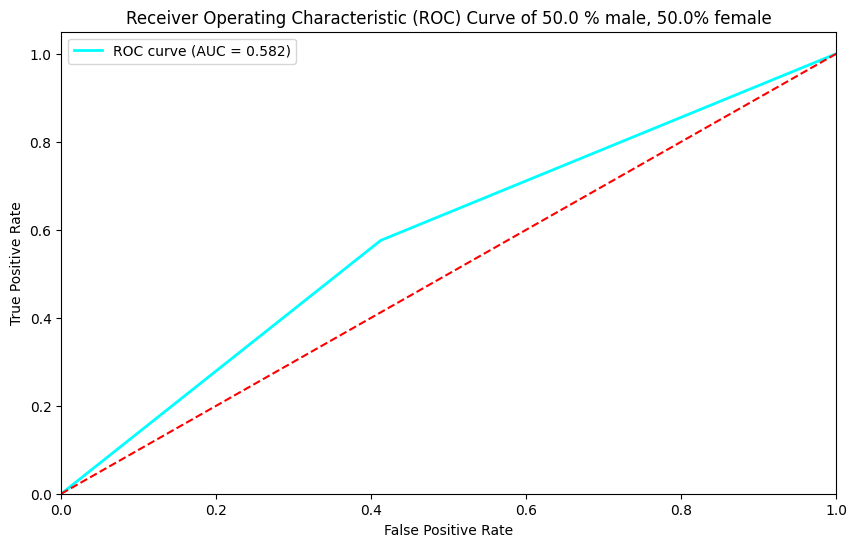


 Prevalence:0.7	 Accuracy: 0.708	 F1-score:0.826	 AUROC:0.625



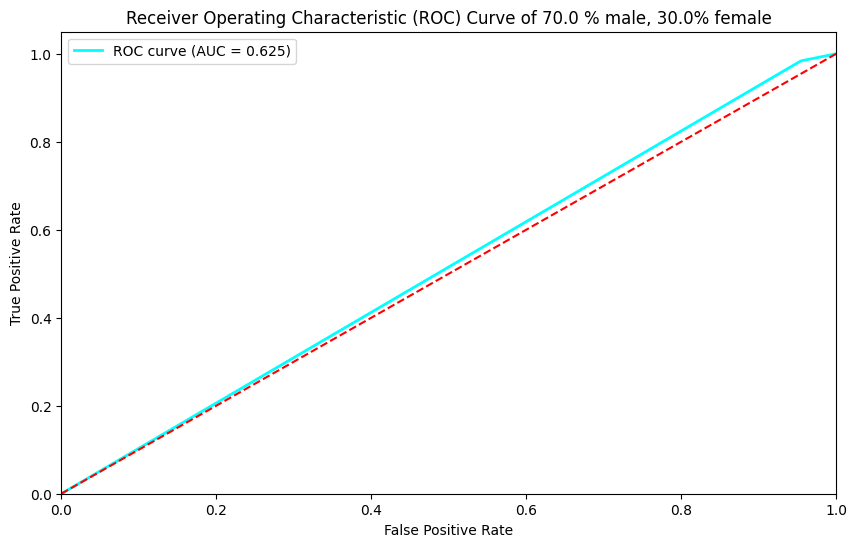


 Prevalence:0.8	 Accuracy: 0.807	 F1-score:0.893	 AUROC:0.752



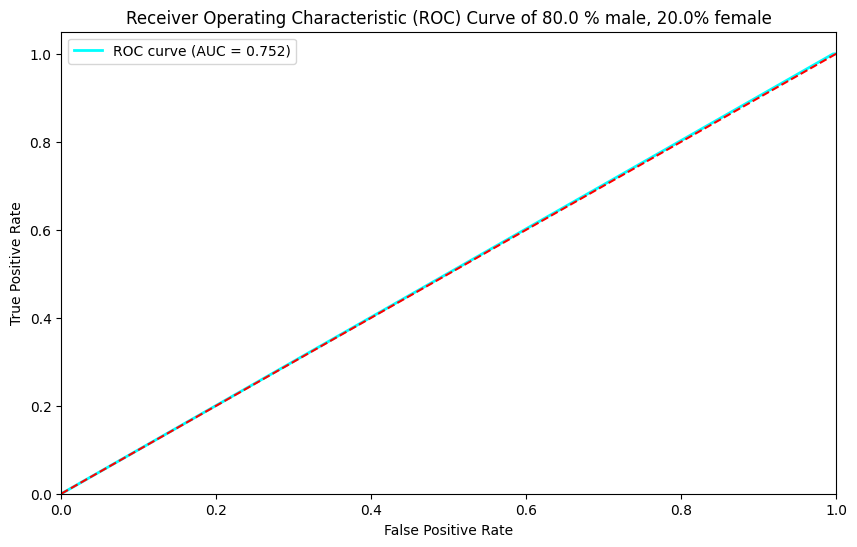

In [ ]:
#IV
# computing the evaluation metrics, including plotting the ROC curve for difference prevalences
prevalence_list = [0.2, 0.3, 0.4, 0.5, 0.7, 0.8]
for prevalence in prevalence_list:
    df_final = final_dataset(prevalence)
    accuracy,f1, roc_auc, fpr, tpr, threshold = model(df_final)
    print(f'\n Prevalence:{prevalence}\t Accuracy: {accuracy:.3f}\t F1-score:{f1:.3f}\t AUROC:{roc_auc:.3f}\n')
    female_prev = (1 - prevalence) * 100
    male_prev = prevalence * 100
    # plot the ROC curve
    plt.figure(figsize = (10,6))
    plt.plot(fpr, tpr, color='cyan', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve of {male_prev:.1f} % male, {female_prev:.1f}% female')
    #plt.grid(False)
    plt.legend(loc= "upper left")
    plt.show()



### (d) Modify your training strategy (loss function) to mitigate the risk of sex bias systematically (in the model training process). Explain the rationale for your choice.


In [ ]:
# Introducing fairness into the model by using the Disparate Impact and a fairness- aware loss function to mitigate the
# sex bias

def disparate_impact(y_true, y_pred, sensitive_attribute):
     """
    Calculate the Disparate Impact (DI), a measure of fairness in classification.

    Parameters:
    y_true (array-like): True binary labels.
    y_pred (array-like): Predicted binary labels.
    sensitive_attribute (array-like): Sensitive attribute binary labels (0 or 1).

    Returns:
    float: Disparate Impact (DI) score, indicating fairness. A DI score of 1 suggests no bias.

    DI measures the difference in positive outcomes between the sensitive group and the non-sensitive group.
    A DI score greater than 1 indicates a favorable outcome bias for the non-sensitive group, while a DI score
    less than 1 suggests a bias in favor of the sensitive group.

    Example usage:
    di = disparate_impact(y_true, y_pred, sensitive_attribute)
    """
    # Calculate disparate impact (DI)
     positive_rate_sensitive = sum(y_pred[sensitive_attribute == 1] == 1) / sum(sensitive_attribute == 1)
     positive_rate_non_sensitive = sum(y_pred[sensitive_attribute == 0] == 1) / sum(sensitive_attribute == 0)
     return positive_rate_non_sensitive / positive_rate_sensitive

# Fairness-aware loss function

def fairness_loss(y_true, y_pred, sensitive_attribute, fairness_weight):
     """
    Calculate the Fairness-Aware Loss incorporating Disparate Impact (DI).

    Parameters:
    y_true (array-like): True binary labels.
    y_pred (array-like): Predicted binary labels.
    sensitive_attribute (array-like): Sensitive attribute binary labels (0 or 1).
    fairness_weight (float): Weighting factor for fairness in the loss function.

    Returns:
    float: Fairness-aware loss value.

    The fairness-aware loss combines the accuracy loss and the fairness consideration, using the DI score
    and the fairness weight. It encourages models to balance fairness and accuracy, with a higher fairness_weight
    emphasizing fairness over accuracy.

    Example usage:
    loss = fairness_loss(y_true, y_pred, sensitive_attribute, fairness_weight)
    """
     di = disparate_impact(y_true, y_pred, sensitive_attribute)
     return accuracy_score(y_true, y_pred) + fairness_weight * (di - 1) ** 2

In [ ]:
# Model training with fairness
def model2(df_final_dataset, fairness_weight):
    X = df_final_dataset[['SBP', 'DBP']]  # Features
    y = df_final_dataset['Gender']  # Target (Gender)
    sensitive_attribute = df_final_dataset['Gender']  # Sensitive attribute (Gender)


    # Set random seed
    np.random.seed(50)
    X_train, X_test, y_train, y_test, sa_train, sa_test = train_test_split(X, y, sensitive_attribute, test_size=0.2, random_state=43, shuffle=True)

    clf = LogisticRegression()

    best_model = None
    best_accuracy = 0
    sample_weights = np.ones(X_train.shape[0])  # Initialize sample weights

    for iteration in range(100):  # Number of iterations for training
        model = clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = model.predict(X_train)

        # Calculate the fairness-aware loss and update sample weights
        fairness_loss_values = fairness_loss(y_train, y_pred, sa_train, fairness_weight)
        sample_weights = np.exp(fairness_loss_values)

        # Use the model to make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    # Use the best model for predictions
    y_pred = best_model.predict(X_test)

    # Evaluate the best model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    return accuracy, f1, roc_auc


In [ ]:
# checking the evaluation performance after fairness is introduced into the model
prevalence = 0.4
df_final_dataset= final_dataset(prevalence)
fairness_weight = 2
accuracy, f1, roc_auc=model2(df_final_dataset, fairness_weight)
print("Original: Prevalence:0.4	 Accuracy: 0.611	 F1-score:0.307	 AUROC:0.586")
print(f'\n With fairness: Prevalence:{prevalence}\t Accuracy: {accuracy:.3f}\t F1-score:{f1:.3f}\t AUROC:{roc_auc:.3f}\n')

Original: Prevalence:0.4	 Accuracy: 0.611	 F1-score:0.307	 AUROC:0.586

 With fairness: Prevalence:0.4	 Accuracy: 0.612	 F1-score:0.308	 AUROC:0.548



With a fairness weight of 2, we are able to acheive an increase in the F1-score from 0.307 to 0.308 and the accuracy from 0.611 to 0.612

###Explain the rationale for your choice.
Below are the reason for choosing the fariness-aware loss function as a way of mitigating the sex bias:

**Fairness-Aware Loss Function:** Utilize a loss function that explicitly considers fairness metrics, such as Disparate Impact (DI), to guide model training. This loss function encourages the model to minimize classification errors and fairness disparities, with a fairness weight hyperparameter controlling the trade-off between accuracy and fairness.

**Rationale for Fairness-Aware Loss:** Incorporating fairness into the loss function aligns with the goal of reducing sex bias in model predictions, providing a systematic approach to balancing accuracy and fairness. It offers transparency and a controlled way to mitigate bias during training.

References:
1. https://pandas.pydata.org/docs/user_guide/10min.html (Accessed November 4th,2023)
2. https://openai.com/chatgpt (Accessed November 4th,2023)